# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Recap" data-toc-modified-id="Recap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recap</a></div><div class="lev1 toc-item"><a href="#The-Edmonds-Karp-Algorithm:-Shortest-Augmenting-Paths" data-toc-modified-id="The-Edmonds-Karp-Algorithm:-Shortest-Augmenting-Paths-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Edmonds-Karp Algorithm: Shortest Augmenting Paths</a></div><div class="lev1 toc-item"><a href="#Dinic's-Algorithm:-Blocking-Flows" data-toc-modified-id="Dinic's-Algorithm:-Blocking-Flows-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dinic's Algorithm: Blocking Flows</a></div>

# Recap

とりあえず、復習がてらFigure 2のグラフの最大流をNetworkXのモジュールを用いて求めてみる。

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Figure2のグラフを生成
G = nx.DiGraph()
G.add_edges_from([('s','v',{'capacity': 1}),
                  ('s','w',{'capacity': 100}),
                  ('w','v',{'capacity': 1}),
                  ('v','t',{'capacity': 100}),
                  ('w','t',{'capacity': 1})])

In [3]:
flow_value, flows = nx.maximum_flow(G,'s','t')
print('maximum flow: {}'.format(flow_value))

caps = nx.get_edge_attributes(G, 'capacity')
for u in nx.topological_sort(G):
    for v, flow in sorted(flows[u].items()):
        print('({}, {}): {}/{}'.format(u, v, flow, caps[(u, v)]))

maximum flow: 3
(s, v): 1/1
(s, w): 2/100
(w, t): 1/1
(w, v): 1/1
(v, t): 2/100


念のため、前回自作したFord Fulkerson algorithmも試してみる。いずれの結果も、the maximum flowが3であることを示している。

In [8]:
#前回作ったやつ
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

def bfsFlowPath(G, s, e):
    '''
    Search a path from s to t all of whose points have strictly positive capacity.
    
    Inputs:
        G: a graph
        s: a start point
        e: an end point
        each edge has two attributes:
            capacity: capacity
            flow: its current flow which should be no more than its capacity
    Output:
        path: a list of edges which represents a path from s to e.
        At each edge of the path, its current flow is strictly less than its capacity.
        In case there is no path from s to t, return None.
    '''

    # 過去に訪れた点を記録
    # sは最初から入れておく
    past = [s]
    # pathを記録するためのリスト
    path = []

    # 全ての点のsからの距離の初期値を無限大に
    for p in G.nodes():
        G.node[p]['dist'] = float('inf')
    
    # node s の距離を0に
    G.node[s]['dist'] = 0
    
    # sに隣接する点をqueueに
    # queueには、今後訪れるべき点が格納される
    queue = deque()
    for p in G.successors(s):
        # current flow < capacity となるedgeだけをpathの候補に
        # flow < capacity となるedge以外は存在しないものとして扱うのと同じ
        if G[s][p]['flow'] < G[s][p]['capacity']:
            queue.append(p)
            
    # あとで条件分岐に用いる
    numberOfSuccessorsOfSource = len(queue)
    
    # sに隣接する点の距離を1に
    for p in queue:
        G.node[p]['dist'] = 1

    # BFSを用いてflow < capacityを満たすsからeへのpathがあるのか調べる
    # pastに過去に訪れた点を格納
    while len(queue)>0:
        v = queue.popleft()
        if v == e: break
        else:
            past.append(v)
            for p in G.successors(v):
                # (過去に訪れていない and flow < capacity)を満たすedge
                if ( (not p in past) and ( G[v][p]['flow'] < G[v][p]['capacity']) ):
                    if ( not p in queue):
                        queue.append(p)
                    if G.node[p]['dist'] > G.node[v]['dist'] + 1:
                        G.node[p]['dist'] = G.node[v]['dist'] + 1

    # sからeへのpathが存在しない場合はNoneを返す
    if numberOfSuccessorsOfSource == 0:
        v = s
    if v != e or v == s:
        # print ('There is no path.')
        return None
    
    # 以下、sからeへのpathが存在する場合
    # 終点から遡ってpathを形成する
    pp = e
    while (1):
        if pp == s: break
            
        pred = G.predecessors(pp)
        count = 0

        for p in pred:
            # ここに、flow < capacity の条件を追加
            if ( G.node[p]['dist'] == G.node[pp]['dist']-1 and G[p][pp]['flow'] < G[p][pp]['capacity']):
                path.insert(0, (p,pp))
                pp = p
                break
            else:
                count += 1
        
        # 条件を満たすedgeがない
        if count == len(pred):
            break

    return path

def makeResidualGraph(G):
    '''
    Input: a graph G
    Output: its residual graph Gf
    '''
    Gf = G.copy()
    edgeList = G.edges()
    
    for edge in edgeList:
        # Initialize flow
        Gf[edge[0]][edge[1]]['flow'] = 0
        
        # 逆向きのedgeがないものは追加
        if not (edge[1], edge[0]) in edgeList:
            Gf.add_edge(edge[1],edge[0])
            Gf[edge[1]][edge[0]]['capacity'] = Gf[edge[0]][edge[1]]['flow']
            Gf[edge[1]][edge[0]]['flow'] = 0
    
    return Gf

def fordFulkerson(G, s, t):
    '''
    Inputs:
        G: a graph
        s: a source vertex
        t: a sink vertex
    Outputs:
        the graph G whose flow was modified by Ford-Fulkerson algorithm
        In case there is no path from s to t, return None.
    '''

    # initialize flows
    for e in G.edges():
        G[e[0]][e[1]]['flow'] = 0

    # Forward edgesを記録
    forwardEdges = G.edges()
    
    # Residual Graphの作成
    Gf = makeResidualGraph(G)
    
    # そもそもGにおいてsからtへのパスがあるのか確認
    path = bfsFlowPath(G, s, t)
    if path == None:
        print ("There is no path from " + str(s) + " to "+ str(t) )
        return None
    
    # Gにおいてsからtへのパスがある場合
    while(1):
        # これ以上パスがみつからない場合は最適なのでそこでループを打ち切る
        path = bfsFlowPath(Gf, s, t)
        if path == None:
            break

        # まだパスがある（最適でない）場合
        else:
            # path上のedgeについて、capacity - flowの最小値を調べる
            diff = float('inf')
            for edge in path:
                diff = np.min([diff, Gf[edge[0]][edge[1]]['capacity'] - Gf[edge[0]][edge[1]]['flow'] ])
            
            # path上のedgeのflowを更新
            for edge in path:
                if edge in forwardEdges:
                    Gf[edge[0]][edge[1]]['flow'] += diff
                    # このとき、backward edgeのcapacityを更新する必要あり？
                    Gf[edge[1]][edge[0]]['capacity'] += diff
                else:
                    Gf[edge[0]][edge[1]]['flow'] -= diff
                    Gf[edge[1]][edge[0]]['capacity'] -= diff
    
    # もともと無かったedgeを消去
    for edge in Gf.edges():
        if not edge in forwardEdges:
            Gf.remove_edge(edge[0],edge[1])
    
    return Gf

In [9]:
T = fordFulkerson(G, 's', 't')

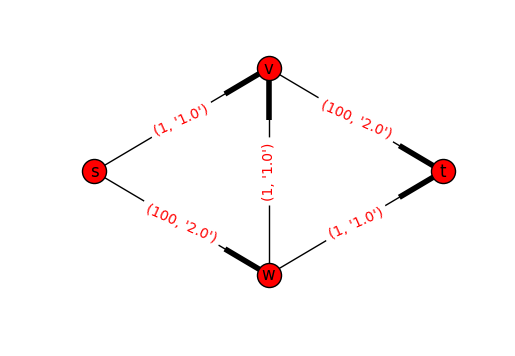

In [10]:
# 描画(edgeに付いている数字は(capacity, 'flow')の意味)

pos={'s':(0,2),'v':(3,4),'w':(3,0),'t':(6,2)}
edge_labels = {(i, j): (w['capacity'], str((w['flow'])) ) for i, j, w in T.edges(data=True)}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_color='r')
nx.draw_networkx_labels(T, pos)
nx.draw(T, pos)
plt.axis('off')
plt.show()

# The Edmonds-Karp Algorithm: Shortest Augmenting Paths

Ford-Fulkerson algorithmではpathの選び方を特に定めていなかった。（そのため、pseudopolynomial-time algorithmになっている。）*Edmonds-Karp algorithm*では、もう少し「賢く」　i.e. the shortest augmenting pathになるようにpathを選ぶ。こちらは、$O(m^2n)$ timeのalgorithmになっている。

BFSを用いればpathは自然とshortestになるので、前回作った*fordFulkerson*は実は*Edmonds-Karp algorithm*にもなっている。

# Dinic's Algorithm: Blocking Flows

BFSを用いてblocking flowsを求めると$O(m^2)$の時間がかかるが、Problem Sets #1 にあるDFSを持ちいた方法を用いれば$O(mn)$の時間で求められるらしい。Lemma 4.2と併せれば、Dinic's algorithmの所要時間は$O(mn^2)$となり、EK algorithmより効率的なalgorithmになる。

実装は後日余裕があれば。